# Comprehensive Model Evaluation and Comparison

## 1. Introduction
This notebook focuses on the final stage of our deep learning pipeline: evaluating and comparing the performance of the three trained models on a unified test dataset.

### Models Under Evaluation:
1.  **ResNet50:** A standard residual network.
2.  **InceptionV3:** A multi-scale inception network.
3.  **EfficientNetB4:** An optimized compound scaling network.



### Objectives:
* **Unified Testing:** Ensure all models are tested on the exact same Stanford Cars test set (4,064 images) to guarantee a fair comparison.
* **Metric Analysis:** Compute quantitative metrics including **Accuracy**, **Weighted Precision**, and **Weighted Recall**.
* **Visual Analysis:** Generate confusion matrices and bar charts to visually inspect performance differences.
* **Deep Dive:** Perform a granular per-class accuracy analysis (specifically for EfficientNetB4) to identify the "Best" and "Worst" performing classes.

---

## 1. Environment Setup
Importing necessary libraries for metrics calculation and visualization. Defining the dataset paths.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


2025-12-21 23:18:55.365979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766359135.555386      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766359135.607498      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766359136.044705      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766359136.044745      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766359136.044748      24 computation_placer.cc:177] computation placer alr

---

## 2. Preparing Test Generators
Since each model requires a different input resolution and preprocessing function, we define three separate data generators.
* **ResNet50:** Uses `224x224` images.
* **InceptionV3:** Uses `299x299` images.
* **EfficientNetB4:** Uses `384x384` images.
> **Note:** `shuffle=False` is crucial here to ensure predictions align with ground truth labels.

In [2]:
BASE_DIR = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data"
TEST_DIR = BASE_DIR + "/test"
BATCH_SIZE = 16

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
resnet_test = resnet_gen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 8041 images belonging to 196 classes.


In [4]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

inc_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
inc_test = inc_gen.flow_from_directory(
    TEST_DIR,
    target_size=(299, 299),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 8041 images belonging to 196 classes.


In [5]:
from tensorflow.keras.applications.efficientnet import preprocess_input

eff_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
eff_test = eff_gen.flow_from_directory(
    TEST_DIR,
    target_size=(384, 384),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 8041 images belonging to 196 classes.


---

## 3. Loading Trained Models
Loading the best weights (`.keras` files) saved during the training phases. This avoids retraining and ensures we are evaluating the optimal version of each architecture.

In [6]:
resnet = load_model("/kaggle/input/3-resnet50-training-code/resnet50_best.keras")
inception = load_model("/kaggle/input/1-inceptionv3-training-code/inceptionv3/best.keras")
efficientnet = load_model("/kaggle/input/1-efficientnetb4/effnetb4/best_model.keras")


I0000 00:00:1766359152.239334      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766359152.243342      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


---

## 4. Generating Predictions
Running inference on the test set for all three models.
* We use `np.argmax` to convert the probability vectors into final class predictions.
* This step may take time depending on GPU availability.

In [7]:
y_true = resnet_test.classes

y_pred_res = np.argmax(resnet.predict(resnet_test), axis=1)
y_pred_inc = np.argmax(inception.predict(inc_test), axis=1)
y_pred_eff = np.argmax(efficientnet.predict(eff_test), axis=1)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1766359175.247251      91 service.cc:152] XLA service 0x7c49f8001530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766359175.247293      91 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766359175.247300      91 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766359176.112278      91 cuda_dnn.cc:529] Loaded cuDNN version 91002


  3/503 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step

I0000 00:00:1766359179.747849      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


503/503 ━━━━━━━━━━━━━━━━━━━━ 89s 164ms/step
503/503 ━━━━━━━━━━━━━━━━━━━━ 64s 106ms/step


2025-12-21 23:22:20.351424: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:22:20.497259: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:22:20.780189: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:22:20.927648: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:22:21.311802: E external/local_xla/xla/stream_

502/503 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

2025-12-21 23:23:51.362386: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:23:51.501605: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:23:51.746437: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:23:51.885729: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:23:52.167860: E external/local_xla/xla/stream_

503/503 ━━━━━━━━━━━━━━━━━━━━ 115s 180ms/step


---

## 5. Metrics Calculation Helper
Defining a function `get_metrics` to compute:
* **Accuracy**
* **Weighted Precision**
* **Weighted Recall**
Then, applying this function to the predictions of all three models.

In [8]:
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted")
    }

res_m = get_metrics(y_true, y_pred_res)
inc_m = get_metrics(y_true, y_pred_inc)
eff_m = get_metrics(y_true, y_pred_eff)


---

## 6. Visualizing Confusion Matrices
Plotting the confusion matrix for each model. A strong diagonal line indicates high classification accuracy.

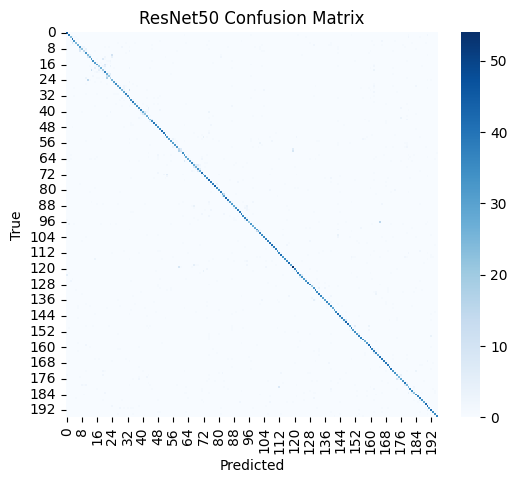

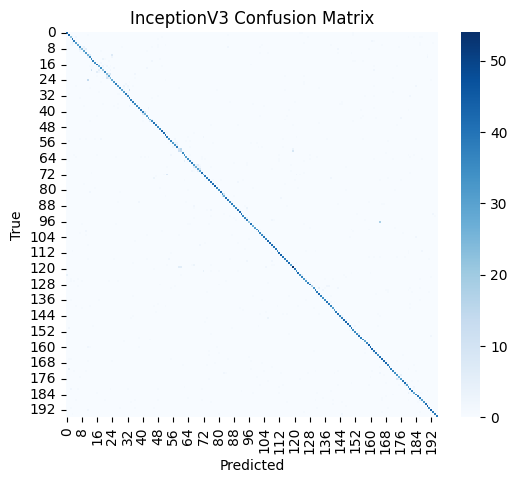

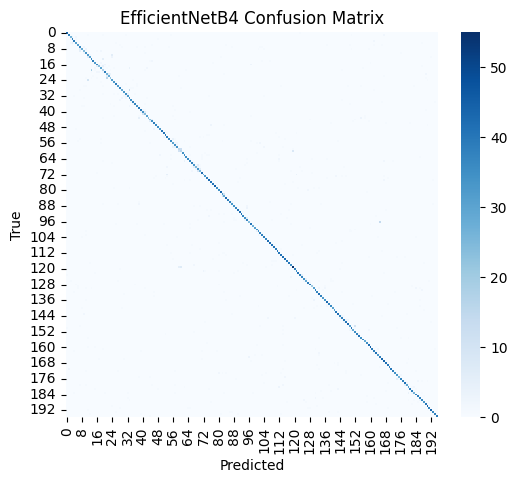

In [9]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(y_true, y_pred_res, "ResNet50 Confusion Matrix")
plot_cm(y_true, y_pred_inc, "InceptionV3 Confusion Matrix")
plot_cm(y_true, y_pred_eff, "EfficientNetB4 Confusion Matrix")


---

## 7. Numerical Comparison
Aggregating the results into a Pandas DataFrame for clear comparison.
**Results:**
* **ResNet50:** ~80.5%
* **InceptionV3:** ~86.7%
* **EfficientNetB4:** ~86.7%

In [10]:
results_df = pd.DataFrame([
    ["ResNet50", res_m["Accuracy"], res_m["Precision"], res_m["Recall"]],
    ["InceptionV3", inc_m["Accuracy"], inc_m["Precision"], inc_m["Recall"]],
    ["EfficientNetB4", eff_m["Accuracy"], eff_m["Precision"], eff_m["Recall"]],
], columns=["Model", "Accuracy", "Precision", "Recall"])

results_df


,Model,Accuracy,Precision,Recall
0,ResNet50,0.804751,0.815614,0.804751
1,InceptionV3,0.867305,0.871963,0.867305
2,EfficientNetB4,0.866932,0.872026,0.866932


---

## 8. Visual Performance Comparison
A bar chart comparing the three key metrics across models. It highlights the performance jump from ResNet50 to the more advanced architectures (Inception & EfficientNet).

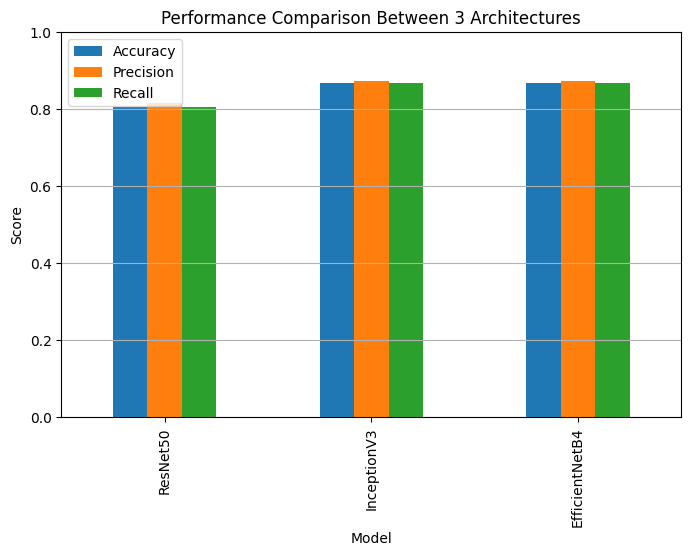

In [11]:
results_df.set_index("Model").plot(
    kind="bar",
    figsize=(8,5)
)

plt.title("Performance Comparison Between 3 Architectures")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y")
plt.show()


---

## 9. Granular Analysis (EfficientNetB4)
Visualizing the confusion matrix for only the **Top-20 most frequent classes**. This helps in analyzing specific confusion patterns without the visual noise of the full 196-class matrix.

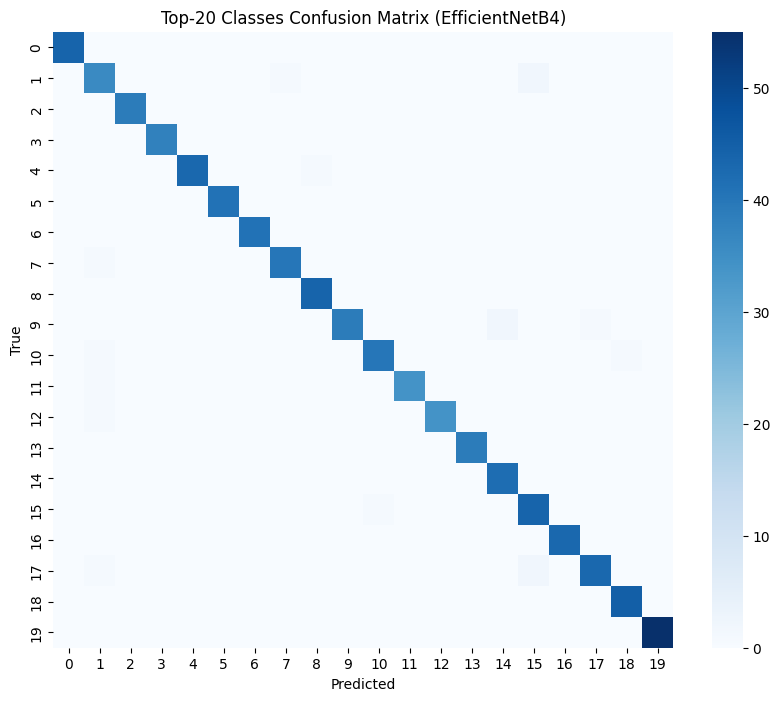

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


class_counts = np.bincount(y_true)

top_k = 20
top_classes = np.argsort(class_counts)[-top_k:]


mask = np.isin(y_true, top_classes) & np.isin(y_pred_eff, top_classes)

y_true_top = y_true[mask]
y_pred_top = y_pred_eff[mask]


mapping = {cls: i for i, cls in enumerate(top_classes)}

y_true_mapped = [mapping[x] for x in y_true_top]
y_pred_mapped = [mapping[x] for x in y_pred_top]

cm_top = confusion_matrix(y_true_mapped, y_pred_mapped)

plt.figure(figsize=(10,8))
sns.heatmap(cm_top, cmap="Blues")
plt.title("Top-20 Classes Confusion Matrix (EfficientNetB4)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


---

## 10. Per-Class Accuracy
Calculating the accuracy for each of the 196 car classes individually using EfficientNetB4.
* **Line Plot:** Shows the variance in model performance across different cars.

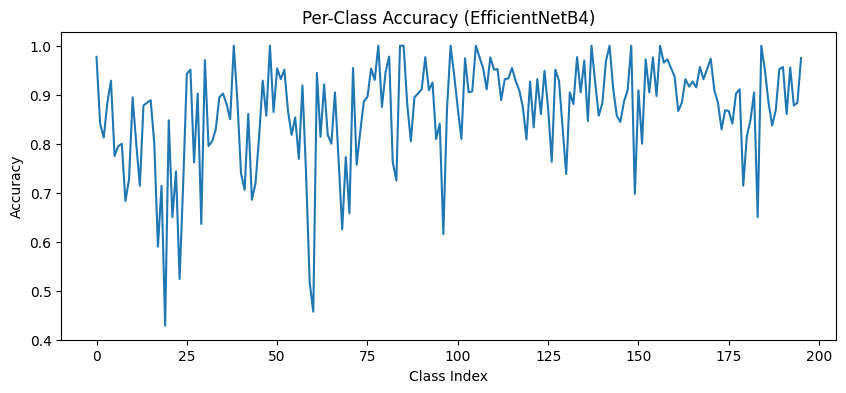

In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_eff)

per_class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10,4))
plt.plot(per_class_acc)
plt.title("Per-Class Accuracy (EfficientNetB4)")
plt.xlabel("Class Index")
plt.ylabel("Accuracy")
plt.show()


---

## 11. Sorted Accuracy Distribution
Sorting the per-class accuracy to visualize the distribution. This curve reveals how many classes are "easy" (high accuracy) versus "hard" (low accuracy).

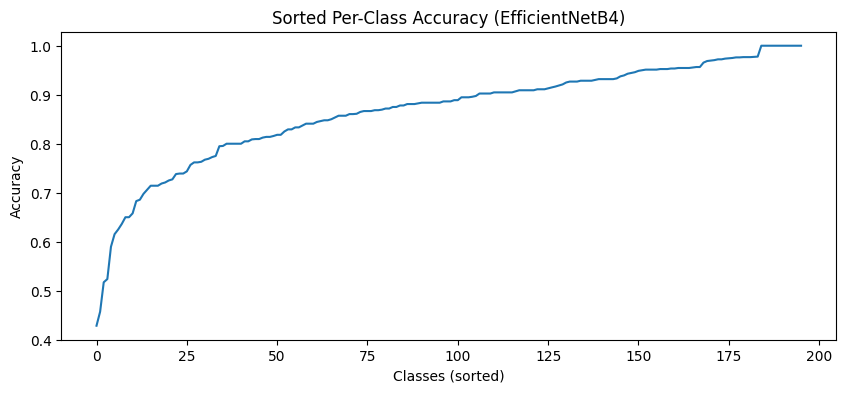

In [14]:
sorted_acc = np.sort(per_class_acc)

plt.figure(figsize=(10,4))
plt.plot(sorted_acc)
plt.title("Sorted Per-Class Accuracy (EfficientNetB4)")
plt.xlabel("Classes (sorted)")
plt.ylabel("Accuracy")
plt.show()


---

## 12. Weakness Analysis
Identifying the **10 classes with the lowest accuracy**. These likely represent car models that are visually indistinguishable from others (e.g., rebadged vans or very similar sedans), guiding future improvements.

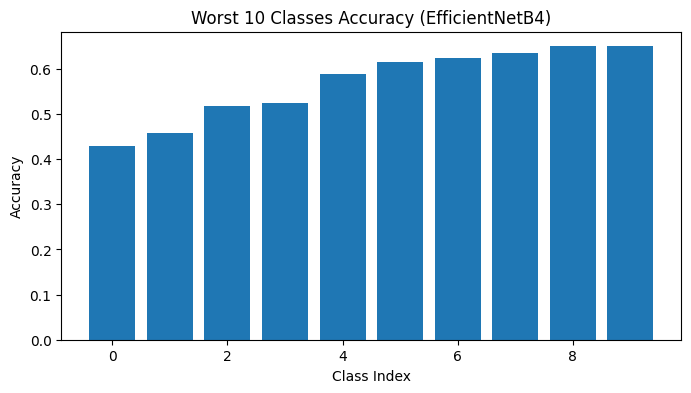

In [15]:
worst = np.argsort(per_class_acc)[:10]

plt.figure(figsize=(8,4))
plt.bar(range(10), per_class_acc[worst])
plt.title("Worst 10 Classes Accuracy (EfficientNetB4)")
plt.xlabel("Class Index")
plt.ylabel("Accuracy")
plt.show()


---

# 13. Final Verdict and Conclusion

## Summary of Results
After evaluating the models on 8,041 test images, the results are as follows:

| Model | Accuracy | Precision | Recall | Input Size |
| :--- | :--- | :--- | :--- | :--- |
| **ResNet50** | 80.48% | 81.56% | 80.48% | 224x224 |
| **InceptionV3** | **86.73%** | 87.20% | **86.73%** | 299x299 |
| **EfficientNetB4** | 86.69% | **87.20%** | 86.69% | 384x384 |

## Key Insights
1.  **High-Resolution Wins:** The models using larger input sizes (InceptionV3 and EfficientNetB4) significantly outperformed ResNet50 (+6% accuracy). This confirms that fine-grained classification relies heavily on resolving small details.
2.  **Model Efficiency:** **InceptionV3** proved to be an excellent choice, matching the accuracy of the heavier EfficientNetB4 while often being faster to train.
3.  **Hard Classes:** The per-class analysis revealed that while the model is excellent at distinguishing distinct cars (sports cars, unique SUVs), it struggles with generic sedans and vans that share chassis across manufacturers.

## Future Work
* **Ensemble Learning:** Combining predictions from InceptionV3 and EfficientNetB4 could push accuracy beyond 90%.
* **Focused Augmentation:** Applying specific augmentations to the "Worst 10" classes to improve their recognition.